In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster.elbow import kelbow_visualizer
from collections import Counter
import matplotlib
from sklearn.metrics import r2_score
from surprise import Dataset, Reader, accuracy
from surprise import KNNWithMeans, KNNBasic
from surprise.model_selection import train_test_split

In [2]:
data = pd.read_csv("data_5/sample_transations.csv", index_col=['Unnamed: 0'], parse_dates=['date'])

In [3]:
data.tail()

,dd_card_number,store_number,dd_transaction_number,sku,quantity,post_discount_price,date,hour,dbi_item_catgry,dbi_item_sub_catgry,dbi_item_famly_name,dbi_item_size
51934,99,172,8155,75,1,2.49,2016-07-09,Morning,Beverages,Hot Coffee,Hot Coffee,X-Large
51935,99,172,8155,111,2,1.98,2016-07-09,Morning,Food - Bakery,Donut Varieties,Traditional Donut,1 Donut
51936,99,172,8155,386,1,1.89,2016-07-09,Morning,Beverages,Cooler Beverages,Sport,Sport
51937,99,172,8165,75,1,2.49,2016-07-11,Night,Beverages,Hot Coffee,Hot Coffee,X-Large
51938,99,172,8165,111,2,1.98,2016-07-11,Night,Food - Bakery,Donut Varieties,Traditional Donut,1 Donut


In [4]:
def get_season(row):
    season = None
    month = row.date.month
    if month in [3,4,5]:
        season = 0 #spring
    elif month in [6,7,8]:
        season = 1 #summer
    elif month in [9,10,11]:
        season = 2 #autumn
    elif month in [12,1,2]:
        season = 3 #winter
    return season

In [5]:
data['season'] = data.apply(get_season, axis=1)
data['week_day'] = data.date.dt.weekday

## Task-1 Clustering

In [6]:
product_info = pd.DataFrame()
#Average Price
product_info['avg_price'] = data.groupby(['sku']).post_discount_price.mean()
#How many different customers buy this item
product_info['bought_by'] = data.groupby(['sku']).dd_card_number.nunique()
#How many different stores sell this item
product_info['sale_by'] = data.groupby(['sku']).store_number.nunique()
#Number of purchases at different hour
for hour in data.hour.unique():
    product_info[hour] = data.groupby(['sku','hour'])[['quantity']].sum().query('hour == @hour').droplevel(1)
#Number of purchases at different week day
for week_day in data.week_day.unique():
    product_info['wd_'+str(week_day)] = data.groupby(['sku','week_day'])[['quantity']].sum().query('week_day == @week_day').droplevel(1)

In [7]:
#In which season product had maximum sale
product_info['season'] = data.groupby(['sku','season']).quantity.sum()\
    .reset_index()\
    .set_index('season')\
    .groupby(['sku']).quantity.agg(lambda x: x.idxmax())
#Product family name
product_info['family_name'] = data.groupby(['sku']).dbi_item_famly_name.first()
#total sale in spring 
product_info['spring_sale'] = data.groupby(['sku','season'])[['quantity']].sum().query('season == 0').droplevel(1)
#total sale in summer
product_info['summer_sale'] = data.groupby(['sku','season'])[['quantity']].sum().query('season == 1').droplevel(1)
#total sale in autumn 
product_info['autumn_sale'] = data.groupby(['sku','season'])[['quantity']].sum().query('season == 2').droplevel(1)
#total sale in winter 
product_info['winter_sale'] = data.groupby(['sku','season'])[['quantity']].sum().query('season == 3').droplevel(1)

In [8]:
temp = product_info.copy(True)

In [9]:
product_info['family_name'] = LabelEncoder().fit_transform(product_info.family_name)

In [10]:
product_info = product_info.fillna(0)

In [11]:
product_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 620 entries, 0 to 619
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   avg_price    620 non-null    float64
 1   bought_by    620 non-null    int64  
 2   sale_by      620 non-null    int64  
 3   Lunch        620 non-null    float64
 4   Morning      620 non-null    float64
 5   Afternoon    620 non-null    float64
 6   Night        620 non-null    float64
 7   wd_2         620 non-null    float64
 8   wd_4         620 non-null    float64
 9   wd_6         620 non-null    float64
 10  wd_0         620 non-null    float64
 11  wd_5         620 non-null    float64
 12  wd_1         620 non-null    float64
 13  wd_3         620 non-null    float64
 14  season       620 non-null    int64  
 15  family_name  620 non-null    int32  
 16  spring_sale  620 non-null    float64
 17  summer_sale  620 non-null    float64
 18  autumn_sale  620 non-null    float64
 19  winter_s

In [12]:
product_info = StandardScaler().fit_transform(product_info)

In [13]:
product_info = shuffle(product_info, random_state=25)

### Apply Elbow method: To get optimal number of clusters

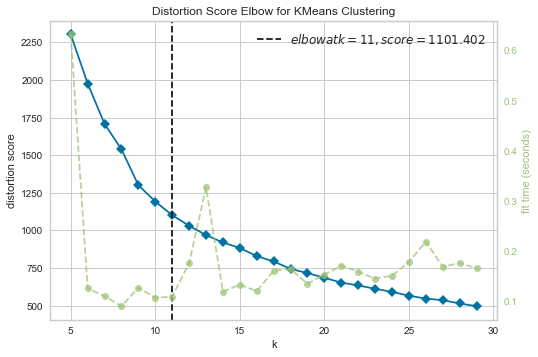

C:\ProgramData\Anaconda3\envs\ml\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x0000011B89C06F48>,
                 k=None, locate_elbow=True, metric='distortion', model=None,
                 timings=True)

In [14]:
K = range(5, 30)
kelbow_visualizer(KMeans(max_iter=1000, random_state=10), product_info,k=K)

In [15]:
n_clusters = 11
kmeanModel = KMeans(n_clusters=n_clusters, random_state=20).fit(product_info)

In [16]:
clusters_size = zip(range(n_clusters), np.bincount(kmeanModel.labels_))
pd.DataFrame([*clusters_size], columns=['Cluster_Number','Cluster_Size']).set_index('Cluster_Number')

,Cluster_Size
Cluster_Number,
0,115
1,2
2,51
3,5
4,122
5,140
6,22
7,1
8,18


Text(0.5, 0, 'Cluster')

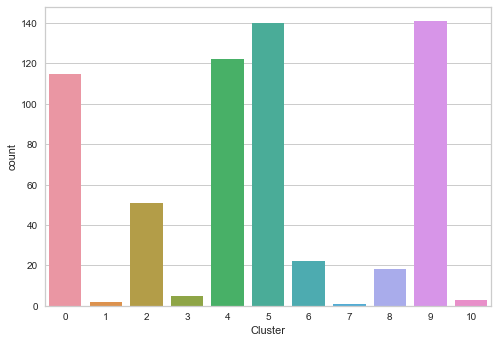

In [17]:
ax = sns.countplot(kmeanModel.labels_)
ax.set_xlabel('Cluster')

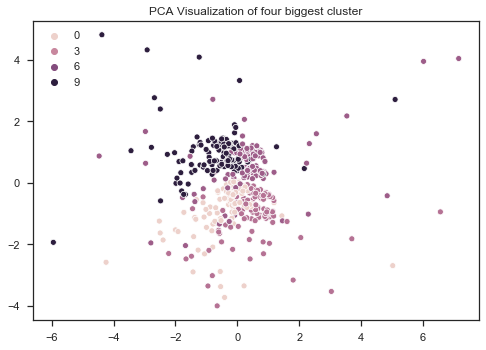

In [18]:
labels = kmeanModel.labels_
masks = np.vectorize(lambda labels: labels in [0,4,5,9])(labels)
labels = labels[masks]
X = StandardScaler().fit_transform(product_info[masks])
X = PCA(n_components=5).fit_transform(X)

sns.set(style="ticks", color_codes=True)
ax = sns.scatterplot(x=X[:, 1], y=X[:, 2], hue=labels)
ax.set_title("PCA Visualization of four biggest cluster")
plt.show()

## Task-2 Recommender system

In [19]:
data = pd.read_csv("data_5/sample_transations.csv", index_col=['Unnamed: 0'], parse_dates=['date'])

In [20]:
user_item = data.groupby(['dd_card_number', 'sku']).quantity.sum().reset_index()
user_item['count'] = user_item.groupby('dd_card_number')['quantity'].transform('sum')
user_item['percentage'] = ((user_item['quantity']*100)/user_item['count']).round(1)

In [21]:
reader = Reader(rating_scale=(0, 100))
data = Dataset.load_from_df(user_item[['dd_card_number','sku','percentage']], reader)
train_set, test_set = train_test_split(data, test_size=0.2)

In [22]:
sim_options = {
    "name": "cosine",
    "user_based": True,  
}
model = KNNWithMeans(k=20, sim_options=sim_options)
model = KNNBasic(k=30, min_k=2, sim_options=sim_options)
model.fit(train_set)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [23]:
predictions = model.test(test_set)

In [24]:
#number of items bought by given user
def get_Iu(uid):
    try:
        return len(train_set.ur[train_set.to_inner_uid(uid)])
    except ValueError:  
        return 0
#number of users that have bought given item
def get_Ui(iid):
    try:
        return len(train_set.ir[train_set.to_inner_iid(iid)])
    except ValueError:
        return 0

In [25]:
df_predictions = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_predictions['err'] = abs(df_predictions.est - df_predictions.rui)
df_predictions['Iu'] = df_predictions.uid.apply(get_Iu)
df_predictions['Ui'] = df_predictions.iid.apply(get_Ui)

In [26]:
best_recommendations = df_predictions.sort_values(by='err')[:3]
worst_recommendations = df_predictions.sort_values(by='err')[-3:]

In [27]:
best_recommendations 

,uid,iid,rui,est,details,err,Iu,Ui
645,14,71,0.2,0.200000,"{'actual_k': 2, 'was_impossible': False}",0.000000,37,2
542,36,43,0.2,0.197723,"{'actual_k': 12, 'was_impossible': False}",0.002277,79,12
407,2,93,0.8,0.794765,"{'actual_k': 28, 'was_impossible': False}",0.005235,8,28


In [28]:
worst_recommendations

,uid,iid,rui,est,details,err,Iu,Ui
751,14,74,52.6,10.828082,"{'actual_k': 30, 'was_impossible': False}",41.771918,37,63
88,12,77,57.3,6.384149,"{'actual_k': 30, 'was_impossible': False}",50.915851,44,61
223,19,74,72.4,13.363478,"{'actual_k': 30, 'was_impossible': False}",59.036522,17,63


### Performance Matrices

In [29]:
y_true = np.array(test_set)[:,2]
y_pred = df_predictions.est

In [30]:
pd.DataFrame([['RMSE',accuracy.rmse(predictions, verbose=False)],
              ['MSE',accuracy.mse(predictions, verbose=False)],
              ['MAE',accuracy.mae(predictions, verbose=False)],
              ['R^2',r2_score(y_true, y_pred)]]).set_index(0)

,1
0,
RMSE,5.937761
MSE,35.257001
MAE,2.637610
R^2,0.168656


<IPython.core.display.Javascript object>


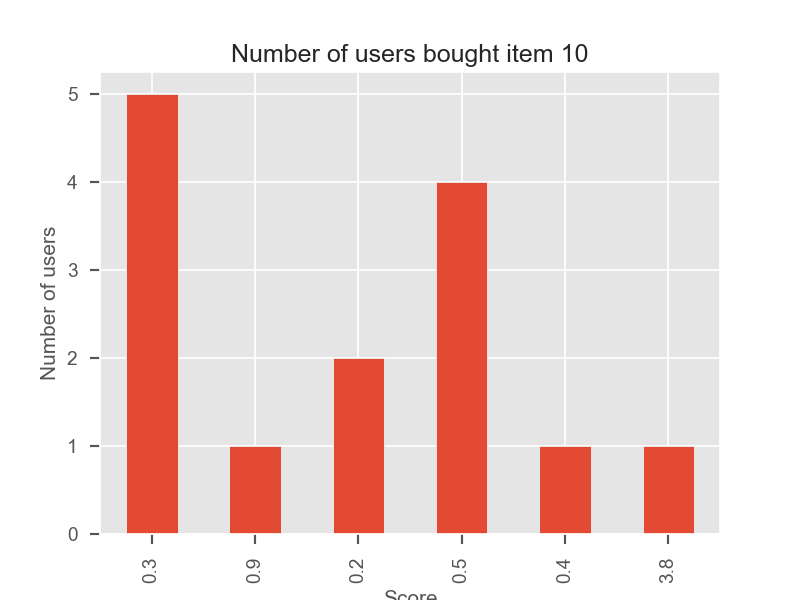

Text(0.5, 1.0, 'Number of users bought item 10')

In [31]:
%matplotlib notebook
matplotlib.style.use('ggplot')
counter = Counter([r for (_, r) in train_set.ir[train_set.to_inner_iid(3)]])
pd.DataFrame.from_dict(counter, orient='index').plot(kind='bar', legend=False)
plt.xlabel('Score')
plt.ylabel('Number of users')
plt.title('Number of users bought item 10')